In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import notebook
from multiprocessing import Pool

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator 

Using TensorFlow backend.


In [2]:
src_dir = '../input/lyft-udacity-challenge/dataA/dataA'

In [3]:
input_imgs_names = os.listdir(os.path.join(src_dir,'CameraRGB'))
mask_names = os.listdir(os.path.join(src_dir,'CameraSeg'))

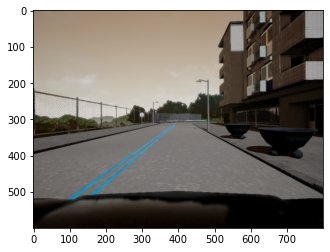

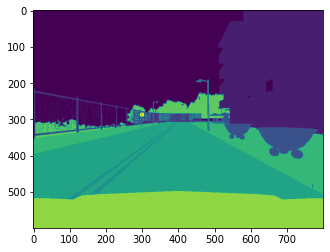

In [4]:
index = random.randint(0,len(input_imgs_names)-1)

img = cv2.imread(os.path.join(src_dir,'CameraRGB',input_imgs_names[index]))
mask = cv2.imread(os.path.join(src_dir,'CameraSeg',mask_names[index]))

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(mask[:,:,2])

In [5]:
def split_img(mask_img):    
    new_mask_img = np.zeros((mask_img.shape[0],mask_img.shape[1],3))
    
    for j in range(1,4):
        for k in range(mask_img.shape[0]):
            for l in range(mask_img.shape[1]):
                if mask_img[k,l] == j:
                    new_mask_img[k,l,j-1] = j;
    return new_mask_img

In [6]:
dest_dir = '/kaggle/working/'

os.makedirs(os.path.join(dest_dir,'Inputs'), exist_ok = True)
os.makedirs(os.path.join(dest_dir,'Outputs'), exist_ok = True)



(272, 400)
(272, 400, 3)


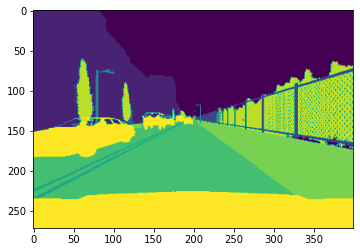

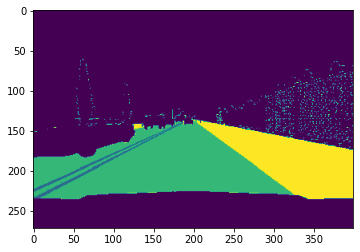

In [7]:
N = 5
mask_img = cv2.imread(os.path.join(src_dir,'CameraSeg',mask_names[N]))
mask_img = cv2.resize(mask_img,(400,272))

new_mask = np.zeros((272, 400))
new_mask[np.where(mask_img==6)[0],np.where(mask_img==6)[1]] = 1
new_mask[np.where(mask_img==7)[0],np.where(mask_img==7)[1]] = 2
new_mask[np.where(mask_img==8)[0],np.where(mask_img==8)[1]] = 3
print(new_mask.shape)
print(mask_img.shape)
plt.figure()
plt.imshow(mask_img[:, :, 2])

plt.figure()
plt.imshow(new_mask.reshape(mask_img.shape[0], mask_img.shape[1]))

In [8]:
input_images = []
mask_images = []

for i in notebook.tqdm(range(1000)):
    input_img = cv2.imread(os.path.join(src_dir,'CameraRGB',input_imgs_names[i]))
    input_img = cv2.resize(input_img, (400,280))
    input_images.append(input_img)
#     inp_file = 'inp_'+str(i)+'.png'
#     cv2.imwrite(os.path.join(dest_dir,'Inputs',inp_file), input_img)

    mask_img = cv2.imread(os.path.join(src_dir,'CameraSeg',mask_names[i]))
    mask_img = cv2.resize(mask_img,(400,272))
    
    newimg = np.zeros((272, 400, 1))
    newimg[np.where(mask_img==6)[0],np.where(mask_img==6)[1]] = 1
    newimg[np.where(mask_img==7)[0],np.where(mask_img==7)[1]] = 2
    newimg[np.where(mask_img==8)[0],np.where(mask_img==8)[1]] = 3
    
    
#     newimg = np.zeros((mask_img.shape[0],mask_img.shape[1]))
    
#     newimg[np.where(mask_img==7)[0],np.where(mask_img==7)[1]] = 1
#     op_img = mask_img[:,:,2]
    
#     op_file = 'op_'+str(i)+'.png'
#     cv2.imwrite(os.path.join(dest_dir,'Outputs',op_file), op_img)

    mask_images.append(newimg)


In [9]:
input_images = np.array(input_images)
input_images = input_images/255.
mask_images = np.array(mask_images)
mask_images = mask_images.reshape((mask_images.shape[0], mask_images.shape[1], mask_images.shape[2], 1))

print(input_images.shape, mask_images.shape)

(1000, 280, 400, 3) (1000, 272, 400, 1)


280 400 3
(272, 400, 1)


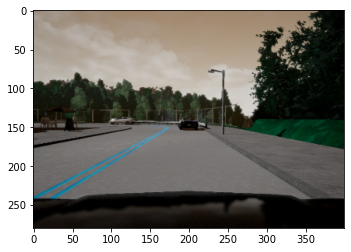

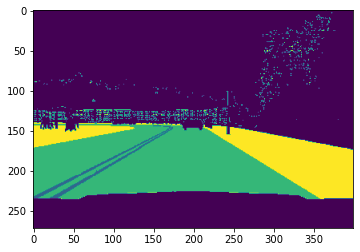

In [10]:
index = random.randint(0,1000)

# input_file = os.listdir(os.path.join(dest_dir, 'Inputs'))[index]
# output_file = os.listdir(os.path.join(dest_dir, 'Outputs'))[index]

# input_img = cv2.imread(os.path.join(dest_dir, 'Inputs', input_file))
# output_img = cv2.imread(os.path.join(dest_dir, 'Outputs', output_file), 0)

# print(input_img.shape, output_img.shape)

input_img = input_images[index]
output_img = mask_images[index]

img_ht = input_img.shape[0]
img_wd = input_img.shape[1]
img_ly = input_img.shape[2]

print(img_ht, img_wd, img_ly)

plt.figure()
plt.imshow(input_img)
print(output_img.shape)
plt.figure()
plt.imshow(output_img.reshape(output_img.shape[0], output_img.shape[1]))

# print(output_img)


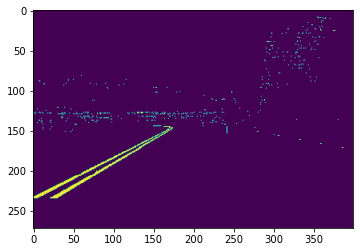

In [11]:
new_img = np.zeros((272, 400))

new_img[np.where(output_img==1)[0],np.where(output_img==1)[1]] = 1
plt.figure()
plt.imshow(new_img.reshape(output_img.shape[0], output_img.shape[1]))

In [12]:
datagen = ImageDataGenerator(validation_split = 0.1)

training_generator = datagen.flow(input_images, mask_images, batch_size = 32, subset = 'training')
validation_generator = datagen.flow(input_images, mask_images, batch_size = 32, subset = 'validation')


In [13]:
main_input = Input(shape=(img_ht,img_wd,img_ly), name = 'img_input')

''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(main_input)
c1 = LeakyReLU(0.2)(c1)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c1)
c1 = LeakyReLU(0.2)(c1)
c1 = BatchNormalization()(c1)

print("c1: "+str(c1.shape))

p1 = MaxPooling2D((2,2))(c1)

print("p1: "+str(p1.shape))

c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(p1)
c2 = LeakyReLU(0.2)(c2)
c2 = BatchNormalization()(c2)
c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c2)
c2 = LeakyReLU(0.2)(c2)
c2 = BatchNormalization()(c2)

print("c2: "+str(c2.shape))

p2 = MaxPooling2D((2,2))(c2)

print("p2: "+str(p2.shape))

c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(p2)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32*2, kernel_size=(1,1), padding = 'same')(c3)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)
c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c3)
c3 = LeakyReLU(0.2)(c3)
c3 = BatchNormalization()(c3)

print("c3: "+str(c3.shape))

p3 = MaxPooling2D((2,2))(c3)

print("p3: "+str(p3.shape))

c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p3)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(32*4, kernel_size=(1,1), padding = 'same')(c4)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)
c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(c4)
c4 = LeakyReLU(0.2)(c4)
c4 = BatchNormalization()(c4)

print("c4: "+str(c4.shape))

p4 = MaxPooling2D((2,2))(c4)

print("p4: "+str(p4.shape))

c5 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p4)
c5 = LeakyReLU(0.2)(c5)
c5 = BatchNormalization()(c5)

print("c5: "+str(c5.shape))


''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

u1 = UpSampling2D((2,2))(c5)
print("u1: "+str(u1.shape))
concat1 = concatenate([u1, Cropping2D(((0,1), (0,0)))(c4)])
print("concat1: "+str(concat1.shape))
c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(concat1)
c6 = LeakyReLU(0.2)(c6)
c6 = BatchNormalization()(c6)
c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c6)
c6 = LeakyReLU(0.2)(c6)
c6 = BatchNormalization()(c6)

print("c6: "+str(c6.shape))

u2 = UpSampling2D((2,2))(c6)
print("u2: "+str(u2.shape))
concat2 = concatenate([Cropping2D(((1,1), (0,0)))(c3), u2])
print("concat2: "+str(concat2.shape))
c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(concat2)
c7 = LeakyReLU(0.2)(c7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c7)
c7 = LeakyReLU(0.2)(c7)
c7 = BatchNormalization()(c7)

print("c7: "+str(c7.shape))

u3 = UpSampling2D((2,2))(c7)
print("u3: "+str(u3.shape))
concat3 = concatenate([Cropping2D(((2,2), (0,0)))(c2), u3])
print("concat3: "+str(concat3.shape))

c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(concat3)
c8 = LeakyReLU(0.2)(c8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c8)
c8 = LeakyReLU(0.2)(c8)
c8 = BatchNormalization()(c8)

print("c8: "+str(c8.shape))

u4 = UpSampling2D((2,2))(c8)
print("u4: "+str(u4.shape))
concat4 = concatenate([Cropping2D(((4,4),(0,0)))(c1), u4])
print("concat4: "+str(concat4.shape))

c9 = Conv2D(16, kernel_size = (1,1), padding = 'same')(concat4)
c9 = LeakyReLU(0.2)(c9)
c9 = BatchNormalization()(c9)
print("c9: "+str(c9.shape))

mask_out = Conv2D(4, (1,1), padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)
print("mask_out: "+str(mask_out.shape))

model = Model(inputs = [main_input], outputs = [mask_out])

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# model.summary()

c1: (None, 280, 400, 32)
p1: (None, 140, 200, 32)
c2: (None, 140, 200, 64)
p2: (None, 70, 100, 64)
c3: (None, 70, 100, 128)
p3: (None, 35, 50, 128)
c4: (None, 35, 50, 192)
p4: (None, 17, 25, 192)
c5: (None, 17, 25, 192)
u1: (None, 34, 50, 192)
concat1: (None, 34, 50, 384)
c6: (None, 34, 50, 128)
u2: (None, 68, 100, 128)
concat2: (None, 68, 100, 256)
c7: (None, 68, 100, 64)
u3: (None, 136, 200, 64)
concat3: (None, 136, 200, 128)
c8: (None, 136, 200, 32)
u4: (None, 272, 400, 32)
concat4: (None, 272, 400, 64)
c9: (None, 272, 400, 16)
mask_out: (None, 272, 400, 4)


In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [15]:
history = model.fit(input_images, mask_images, batch_size=32, epochs = 50, validation_split = 0.1)
# history = model.fit_generator(training_generator,steps_per_epoch=(len(input_images)*0.9)//32, epochs=10, validation_data=validation_generator, validation_steps=(len(input_images)*0.1)//32)

Epoch 1/50
29/29 [==============================] - 15s 518ms/step - loss: 0.9293 - accuracy: 0.7030 - val_loss: 1.7119 - val_accuracy: 0.5215
Epoch 2/50
29/29 [==============================] - 13s 456ms/step - loss: 0.6725 - accuracy: 0.8195 - val_loss: 1.5751 - val_accuracy: 0.4978
Epoch 3/50
29/29 [==============================] - 13s 462ms/step - loss: 0.5588 - accuracy: 0.8199 - val_loss: 0.8583 - val_accuracy: 0.7253
Epoch 4/50
29/29 [==============================] - 13s 454ms/step - loss: 0.4612 - accuracy: 0.8373 - val_loss: 0.8426 - val_accuracy: 0.6883
Epoch 5/50
29/29 [==============================] - 13s 456ms/step - loss: 0.4090 - accuracy: 0.8396 - val_loss: 0.9454 - val_accuracy: 0.7007
Epoch 6/50
29/29 [==============================] - 13s 456ms/step - loss: 0.3582 - accuracy: 0.8600 - val_loss: 0.8276 - val_accuracy: 0.7274
Epoch 7/50
29/29 [==============================] - 13s 461ms/step - loss: 0.3132 - accuracy: 0.8757 - val_loss: 1.0725 - val_accuracy: 0.7256

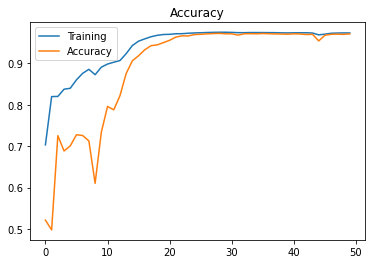

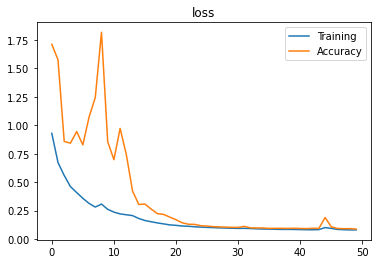

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Accuracy')
plt.title('loss')
plt.legend()

(280, 400, 3)
(1, 272, 400, 4)


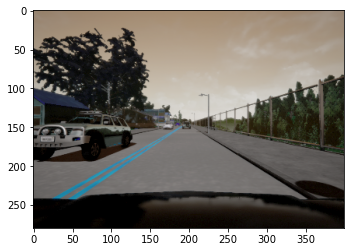

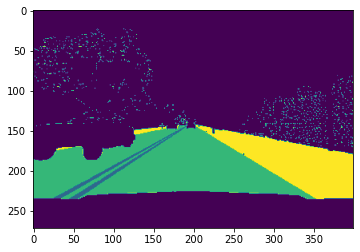

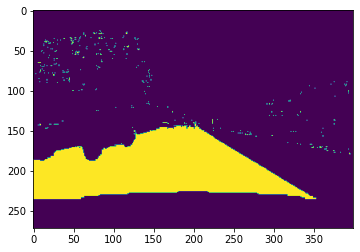

In [17]:
index = random.randint(0,1000)

input_img = input_images[index]
output_img = mask_images[index]

img_ht = input_img.shape[0]
img_wd = input_img.shape[1]
img_ly = input_img.shape[2]

# print(img_ht, img_wd, img_ly)

plt.figure()
plt.imshow(input_img)

plt.figure()
plt.imshow(output_img.reshape(output_img.shape[0], output_img.shape[1]))

print(input_img.shape)

pred = model.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2] )))

print(pred.shape)
                     
newimg = np.zeros((pred.shape[1], pred.shape[2]))

for i in range(2,3):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            if pred[0,j,k,i] > 0.08:
                newimg[j,k] = i

plt.figure()
plt.imshow(newimg)

In [18]:
model.save("/kaggle/working/lane-road-seg-v1.h5")

(280, 400, 3)
(272, 400, 1)
(1, 272, 400, 4)


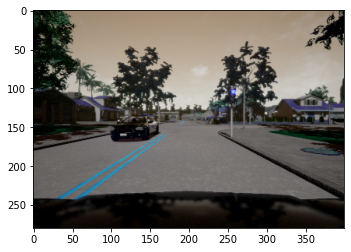

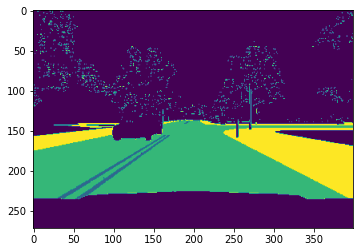

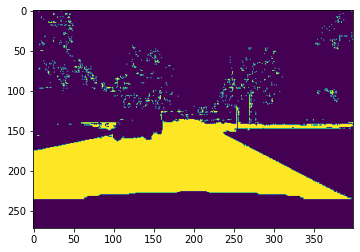

In [19]:
model4 = tf.keras.models.load_model("/kaggle/working/lane-road-seg-v1.h5")
index = random.randint(0,1000)

input_img = input_images[index]
output_img = mask_images[index]

img_ht = input_img.shape[0]
img_wd = input_img.shape[1]
img_ly = input_img.shape[2]

# print(img_ht, img_wd, img_ly)

plt.figure()
plt.imshow(input_img)

plt.figure()
plt.imshow(output_img.reshape(output_img.shape[0], output_img.shape[1]))

print(input_img.shape)
print(output_img.shape)

pred = model4.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2] )))

print(pred.shape)
                     
newimg = np.zeros((pred.shape[1], pred.shape[2]))

for i in range(2,3):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            if pred[0,j,k,i] > 0.08:
                newimg[j,k] = i

plt.figure()
plt.imshow(newimg)